In [99]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('bmh')

In [100]:
tweet_hourly_data = pd.read_csv('./data/tweets_hourly_2018-2022.csv')
btc_hourly_data = pd.read_csv('./data/btc_hourly_2018-2022.csv')

tweet_hourly_data['timestamp'] = pd.to_datetime(tweet_hourly_data['timestamp'], utc=True)
tweet_hourly_data['timestamp'] = tweet_hourly_data['timestamp'].dt.tz_localize(None)

btc_hourly_data['timestamp'] = pd.to_datetime(btc_hourly_data['timestamp'], utc=True)
btc_hourly_data['timestamp'] = btc_hourly_data['timestamp'].dt.tz_localize(None)

tweet_hourly_data.set_index('timestamp', inplace=True)
btc_hourly_data.set_index('timestamp', inplace=True)

tweet_hourly_data.sort_index(inplace=True)
btc_hourly_data.sort_index(inplace=True)

print(tweet_hourly_data.head(2))
print(btc_hourly_data.head(2))

                     replies  likes  retweets  polarity  influence     score
timestamp                                                                   
2018-01-01 00:00:00        9     67        52    1.8279   0.000387  0.000188
2018-01-01 01:00:00        6    288        54    0.1164   0.001007 -0.000354
                        open     high      low    close  volume_btc  \
timestamp                                                             
2018-05-15 06:00:00  8733.86  8796.68  8707.28  8740.99      559.93   
2018-05-15 07:00:00  8740.99  8766.00  8721.11  8739.00      273.58   

                     volume_usd  
timestamp                        
2018-05-15 06:00:00  4906603.14  
2018-05-15 07:00:00  2390398.89  


### Correlation between price and sentiment

In [101]:
start = max(tweet_hourly_data.index.min().replace(tzinfo=None), btc_hourly_data.index.min().replace(tzinfo=None))
end = min(tweet_hourly_data.index.max().replace(tzinfo=None), btc_hourly_data.index.max().replace(tzinfo=None))
tweet_hourly_data = tweet_hourly_data[start:end]
btc_hourly_data = btc_hourly_data[start:end]

print(f"Showing data from {start}-{end}")

Showing data from 2018-05-15 06:00:00-2022-03-01 00:00:00


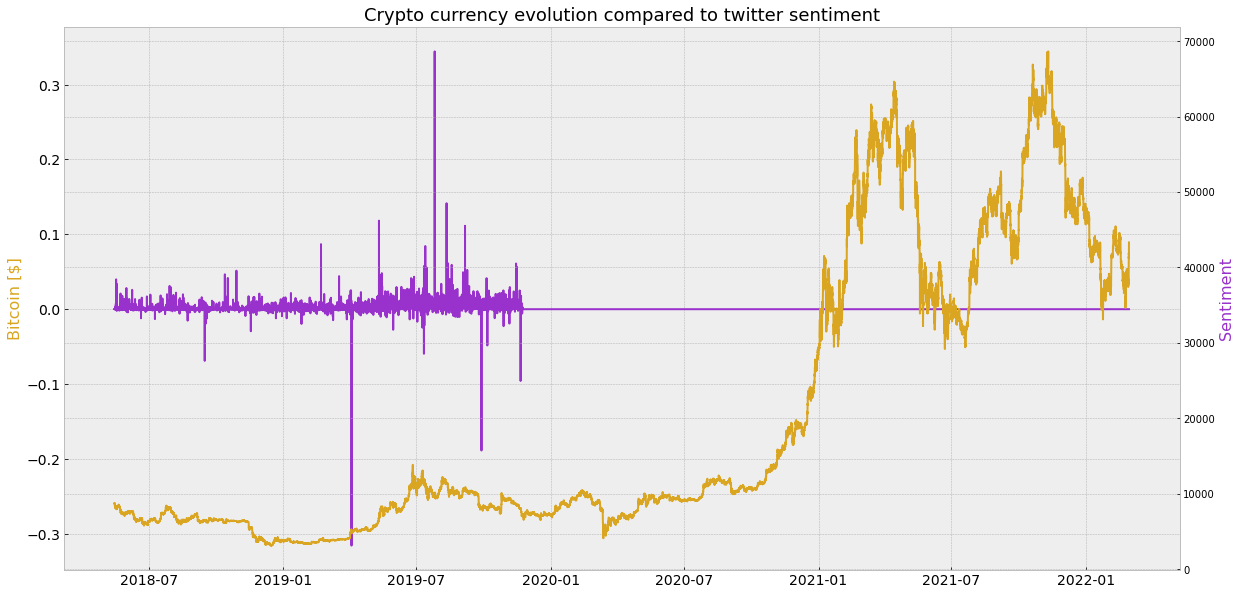

In [111]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweet_hourly_data.index, tweet_hourly_data['score'], 'darkorchid')
ax2.plot_date(btc_hourly_data.index, btc_hourly_data['close'], 'goldenrod')

ax1.set_ylabel("Bitcoin [$]", color='goldenrod', fontsize=16)
ax2.set_ylabel("Sentiment", color='darkorchid', fontsize=16)
plt.show()

In [103]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    return datax.corrwith(datay.shift(lag), method=method)

In [104]:
tweet_scores = tweet_hourly_data[['score']]
btc_price = btc_hourly_data[['close']]
btc_price = btc_price.set_axis(tweet_scores.columns, axis='columns', inplace=False)

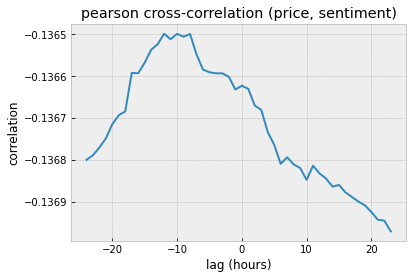

In [105]:
xcov = [crosscorr(tweet_scores, btc_price, lag=i, method="pearson") for i in range(-24,24)]
plt.plot(range(-24,24), xcov)
plt.title("pearson cross-correlation (price, sentiment)")
plt.xlabel("lag (hours)")
plt.ylabel("correlation")
plt.show()